# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 18.5 MB/s eta 0:00:00


In [8]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import os
import boto3
import pandas as pd
import matplotlib.pyplot as plt
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch

from sagemaker.debugger import (
    Rule, ProfilerRule, rule_configs, 
    DebuggerHookConfig, ProfilerConfig, FrameworkProfile,
)

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [3]:
from glob import glob
local_dir ="dogImages/dogImages"
#Length of train, test and validation set images
for i in glob(local_dir+"/*"):
    print("Number of classes "+i.split("/")[-1]+" data split - ",len(glob(i+"/*")))

Number of classes valid data split -  133
Number of classes train data split -  133
Number of classes test data split -  133


### EDA

In [4]:
classes = os.listdir(os.path.join(local_dir,'train'))
num_trainImages = []
num_testImages = []
num_valImages = []
for c in classes:
    num_trainImages.append(len(os.listdir(os.path.join(local_dir,"train",c))))
    num_testImages.append(len(os.listdir(os.path.join(local_dir,"test",c))))
    num_valImages.append(len(os.listdir(os.path.join(local_dir,"valid",c))))
    
df = pd.DataFrame({
    "Dog Breed":list(classes),
    "train":num_trainImages,
    "test":num_testImages,
    "val":num_valImages})
df = df.set_index("Dog Breed")
df

,train,test,val
Dog Breed,,,
123.Pomeranian,44,5,6
030.Border_terrier,52,7,6
063.English_springer_spaniel,53,7,6
119.Petit_basset_griffon_vendeen,31,4,4
131.Wirehaired_pointing_griffon,30,3,4
...,...,...,...
070.German_pinscher,47,6,6
048.Chihuahua,54,7,7
013.Australian_terrier,46,6,6


In [5]:
df.describe()

,train,test,val
count,133.000000,133.000000,133.000000
mean,50.225564,6.285714,6.278195
std,11.863885,1.712571,1.350384
min,26.000000,3.000000,4.000000
25%,42.000000,5.000000,6.000000
50%,50.000000,6.000000,6.000000
75%,61.000000,8.000000,7.000000
max,77.000000,10.000000,9.000000


In [6]:
#Number of images in train,test and val split
df['train'].sum(),df['test'].sum(),df['val'].sum()

(6680, 836, 835)

<AxesSubplot:xlabel='Dog Breed'>

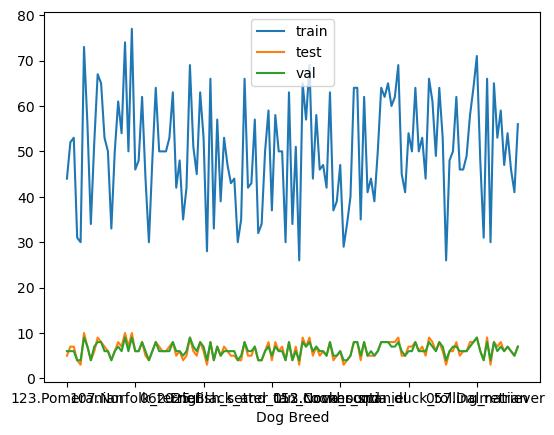

In [7]:
df.plot()

### Insights from EDA
#### From the above exploaration the dataset is not balanced and the average number of images for a class in train set is 50 and in test and validation sets it is 6 images.
#### The total number of images in train,test and val split is the train,test and val data split is 8351 with train,test and val splits as 80,10,10 percent respectively
#### Dog breed classification dataset which has 133 different dog breed images in the train,test and validation set is taken
#### Since the 133 classes are not balanced there might be a bias after training(this is an assumption)

In [ ]:
#TODO: Fetch and upload the data to AWS S3



#Uploading extrcated files to s3
#Uploading extrcated files to s3
import boto3
from tqdm import tqdm
s3 = boto3.client('s3')
from glob import glob
for dataType in glob("dogImages/dogImages/*"):
    for folder in tqdm(glob(dataType+"/*")):
        for i in glob(folder+"/*"):
            s3.upload_file(i, "projects--1", "ImageClassification/"+"/".join(i.split("/")[1:]))

    print('success')

100%|██████████| 133/133 [01:03<00:00,  2.11it/s]


success


100%|██████████| 133/133 [08:54<00:00,  4.02s/it]


success


100%|██████████| 133/133 [01:06<00:00,  1.99it/s]

success


In [2]:
dataset_dir_path = "s3://projects--1/ImageClassification/dogImages"

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [9]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {"lr":ContinuousParameter(0.001,0.1),
                          "batch-size":CategoricalParameter([32,64]),
                          "epochs":CategoricalParameter([1,2])}

objective_metric_name = "average test accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name":"average test accuracy","Regex":"Test set Accuracy: ([0-9\\.]+)"}]

In [10]:
#TODO: Create estimators for your HPs
# TODO: Your estimator here
estimator = PyTorch(entry_point="hpo.py",
                   role=sagemaker.get_execution_role(),
                   py_version="py36",
                   framework_version="1.8",
                   instance_count=1,
                   instance_type="ml.m5.large")

# TODO: Your HP tuner here
tuner = HyperparameterTuner(
                    estimator,
                    objective_metric_name,
                    hyperparameter_ranges,
                    metric_definitions,
                    max_jobs=4,
                    max_parallel_jobs=2,
                    objective_type=objective_type)

In [11]:
# TODO: Fit your HP Tuner
tuner.fit({"data":dataset_dir_path},wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.....................................................................................................................................................!


In [12]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator_hyperparameters = best_estimator.hyperparameters()


2023-02-03 06:06:10 Starting - Found matching resource for reuse
2023-02-03 06:06:10 Downloading - Downloading input data
2023-02-03 06:06:10 Training - Training image download completed. Training in progress.
2023-02-03 06:06:10 Uploading - Uploading generated training model
2023-02-03 06:06:10 Completed - Resource retained for reuse


In [13]:
best_estimator_hyperparameters

{'_tuning_objective_metric': '"average test accuracy"',
 'batch-size': '"64"',
 'epochs': '"2"',
 'lr': '0.05979664684978815',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-02-03-05-53-54-884"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-765184526114/pytorch-training-2023-02-03-05-53-54-884/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [14]:
# Creating the hyperparameters dictionary
hyperparameters = {
    "batch-size": best_estimator_hyperparameters['batch-size'].strip('"'),
    "lr": best_estimator_hyperparameters['lr'],
    "epochs": best_estimator_hyperparameters['epochs'].strip('"')
}

print(hyperparameters)

{'batch-size': '64', 'lr': '0.05979664684978815', 'epochs': '2'}


In [10]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
#TODO: Can you add the rules you want to track
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

#TODO: Can you create the profiler and debugger configs
profiler_config = ProfilerConfig(system_monitor_interval_millis=500,framework_profile_params=FrameworkProfile(num_steps=10))
debugger_config = DebuggerHookConfig(hook_parameters={"train.save_interval":"100","eval.save_interval":"10"})

In [11]:
# TODO: Create and fit an estimator
# TODO: Your estimator here
estimator = PyTorch(entry_point="train_model.py",
    base_job_name="Image-classification-Project-debugging",
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config,
                   )

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [12]:
estimator.fit({'data': dataset_dir_path}, wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.i

2023-02-03 13:00:45 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2023-02-03 13:01:45 Starting - Preparing the instances for training......
2023-02-03 13:02:45 Downloading - Downloading input data.........
2023-02-03 13:04:12 Training - Downloading the training image...
2023-02-03 13:04:46 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-03 13:04:37,067 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-03 13:04:37,071 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-03 13:04:37,080 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.

In [13]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-02-03 13:10:33.144 ip-172-16-133-22.ec2.internal:10346 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-02-03 13:10:33.156 ip-172-16-133-22.ec2.internal:10346 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-765184526114/Image-classification-Project-debugging-2023-02-03-13-00-44-960/debug-output


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [14]:
print(trial.tensor_names())

[2023-02-03 13:10:33.502 ip-172-16-133-22.ec2.internal:10346 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-02-03 13:10:34.531 ip-172-16-133-22.ec2.internal:10346 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 'layer4.1.relu_input_0', 'layer4.1.relu_input_1', 'relu_input_0']


In [15]:
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

1
1


In [16]:
# TODO: Can you print the names of all the tensors that were tracked
print("Name of all the tensors tracked:   ",trial.tensor_names())
# TODO: Can you print the number of datapoints for one of those tensors
# for both train and eval mode
print("Datapoints in train mode:  ",len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print("Datapoints in eval mode:   ",len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

Name of all the tensors tracked:    ['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 'layer4.1.relu_input_0', 'layer4.1.relu_input_1', 'relu_input_0']
Datapoints in train mode:   1
Datapoints in eval mode:    1


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

From the debugger report it is clear that there is a poor weight initialization becuase of ths the training accuracy is not improving

In [23]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [24]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-765184526114/Image-classification-Project-debugging-2023-02-03-13-00-44-960/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-765184526114/Image-classification-Project-debugging-2023-02-03-13-00-44-960/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-765184526114/Image-classification-Project-debugging-2023-02-03-13-00-44-960/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-765184526114/Image-classification-Project-debugging-2023-02-03-13-00-44-960/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profil

In [25]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [26]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

From the profiler report this is clear that most of the time is spent on others, rather than on training and testing. The dataloaders is taking majority of the time.
And also most of the utilization is with cpu

## Model Deploying

In [63]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
import sagemaker
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()
class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [64]:
model_location = "s3://sagemaker-us-east-1-765184526114/Image-classification-Project-debugging-2023-02-03-09-48-34-835/output/model.tar.gz"
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference2.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [65]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Creating model with name: pytorch-inference-2023-02-03-10-52-06-002
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-02-03-10-52-06-523
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-02-03-10-52-06-523


------!

In [79]:
import requests
request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

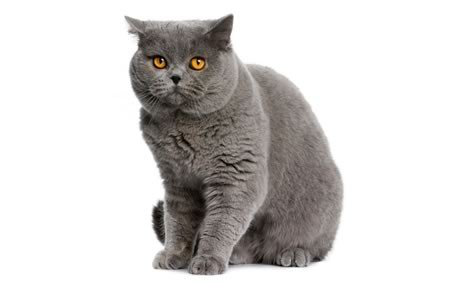

In [80]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [81]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [82]:
import torch
import numpy as np
np.argmax(response, 1)

array([123])

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()